In [ ]:
!pip install langchain langchain_groq langchain-chroma sentence-transformers langgraph langchain_community arxiv tavily-python chromadb

In [ ]:
!pip install wikipedia langchain_tavily

In [1]:
import os
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
os.environ['GROQ_API_KEY'] = GROQ_API_KEY

TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from typing import TypedDict, Annotated, List, Literal
from pydantic import BaseModel, Field
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages
from langchain.schema import Document

# Define Pydantic class for message types
class QueryType(BaseModel):
    """Classification of query type"""
    category: Literal["research", "general", "blogs"] = Field(
        description="Category of the query: research for academic papers, general for encyclopedic knowledge, blogs for current events/opinions"
    )
    confidence: float = Field(
        description="Confidence score between 0 and 1"
    )

# Define State for the graph
class SupervisorState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    query: str
    query_type: QueryType
    search_results: List[Document]
    retrieved_documents: List[Document]
    final_answer: str
    next_action: str

In [4]:
from langchain_groq import ChatGroq
from langchain_community.embeddings import SentenceTransformerEmbeddings

# Initialize LLM
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.3
)

embeddings = SentenceTransformerEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

/tmp/ipython-input-3801392250.py:10: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(


In [5]:
from langchain_community.vectorstores import Chroma

research_vectorstore = Chroma(
    collection_name="research_papers",
    embedding_function=embeddings,
    persist_directory="./research_vectorstore"
)

general_vectorstore = Chroma(
    collection_name="general_knowledge",
    embedding_function=embeddings,
    persist_directory="./general_vectorstore"
)

blogs_vectorstore = Chroma(
    collection_name="blogs_articles",
    embedding_function=embeddings,
    persist_directory="./blogs_vectorstore"
)

/tmp/ipython-input-3339131044.py:3: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  research_vectorstore = Chroma(


In [6]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv.tool import ArxivQueryRun
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Initialize tools
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
arxiv_tool = ArxivQueryRun(api_wrapper=ArxivAPIWrapper())
tavily_tool = TavilySearchResults(max_results=3)

# Text splitter for processing documents
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

/tmp/ipython-input-547652763.py:10: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=3)


In [7]:
def supervisor_node(state: SupervisorState) -> SupervisorState:
    """Classify the query and decide next action"""

    query = state["query"]

    # Create classification prompt
    classification_prompt = f"""
    Classify the following query into one of three categories:
    - "research": For academic papers, scientific research, technical studies
    - "general": For encyclopedic knowledge, definitions, historical facts
    - "blogs": For current events, opinions, news, trending topics

    Query: {query}

    Respond with the category and confidence score (0-1).
    """

    # Use LLM to classify
    structured_llm = llm.with_structured_output(QueryType)
    query_type = structured_llm.invoke(classification_prompt)

    # Check if information exists in vector store
    if query_type.category == "research":
        results = research_vectorstore.similarity_search(query, k=1)
    elif query_type.category == "general":
        results = general_vectorstore.similarity_search(query, k=1)
    else:
        results = blogs_vectorstore.similarity_search(query, k=1)

    # Decide next action based on retrieval results
    if results and len(results) > 0:
        # Check relevance threshold
        next_action = "retrieve_from_vectorstore"
    else:
        next_action = f"search_{query_type.category}"

    return {
        **state,
        "query_type": query_type,
        "next_action": next_action
    }

In [8]:
def search_research_node(state: SupervisorState) -> SupervisorState:
    """Search arXiv for research papers"""

    query = state["query"]

    # Search arXiv
    results = arxiv_tool.run(query)

    # Convert to documents
    documents = [Document(page_content=results, metadata={"source": "arxiv", "query": query})]

    # Split and store in vector database
    split_docs = text_splitter.split_documents(documents)
    research_vectorstore.add_documents(split_docs)

    return {
        **state,
        "search_results": split_docs,
        "next_action": "retrieve_from_vectorstore"
    }

In [9]:
def search_general_node(state: SupervisorState) -> SupervisorState:
    """Search Wikipedia for general knowledge"""

    query = state["query"]

    # Search Wikipedia
    results = wikipedia_tool.run(query)

    # Convert to documents
    documents = [Document(page_content=results, metadata={"source": "wikipedia", "query": query})]

    # Split and store in vector database
    split_docs = text_splitter.split_documents(documents)
    general_vectorstore.add_documents(split_docs)

    return {
        **state,
        "search_results": split_docs,
        "next_action": "retrieve_from_vectorstore"
    }

In [10]:
def search_blogs_node(state: SupervisorState) -> SupervisorState:
    """Search Tavily for blog articles and current content"""

    query = state["query"]

    # Search with Tavily
    results = tavily_tool.invoke(query)

    # Convert results to documents
    documents = []
    for result in results:
        content = result.get('content', '') + " " + result.get('title', '')
        doc = Document(
            page_content=content,
            metadata={"source": "tavily", "url": result.get('url', ''), "query": query}
        )
        documents.append(doc)

    # Split and store in vector database
    split_docs = text_splitter.split_documents(documents)
    blogs_vectorstore.add_documents(split_docs)

    return {
        **state,
        "search_results": split_docs,
        "next_action": "retrieve_from_vectorstore"
    }

In [11]:
def retrieve_from_vectorstore_node(state: SupervisorState) -> SupervisorState:
    """Retrieve relevant documents from appropriate vector store"""

    query = state["query"]
    query_type = state["query_type"]

    # Select appropriate vector store
    if query_type.category == "research":
        vectorstore = research_vectorstore
    elif query_type.category == "general":
        vectorstore = general_vectorstore
    else:
        vectorstore = blogs_vectorstore

    # Retrieve relevant documents
    retrieved_docs = vectorstore.similarity_search(query, k=3)

    return {
        **state,
        "retrieved_documents": retrieved_docs,
        "next_action": "generate_answer"
    }

In [12]:
def generate_answer_node(state: SupervisorState) -> SupervisorState:
    """Generate final answer using retrieved documents"""

    query = state["query"]
    retrieved_docs = state["retrieved_documents"]

    # Prepare context from retrieved documents
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # Create RAG prompt
    rag_prompt = f"""
    Based on the following context, answer the user's question comprehensively and accurately.

    Context:
    {context}

    Question: {query}

    Answer:
    """

    # Generate answer
    response = llm.invoke(rag_prompt)
    final_answer = response.content

    return {
        **state,
        "final_answer": final_answer,
        "messages": state["messages"] + [AIMessage(content=final_answer)]
    }

In [13]:
from langgraph.graph import END
def route_next_action(state: SupervisorState) -> str:
    """Route to next node based on next_action"""
    next_action = state.get("next_action", "")

    if next_action == "search_research":
        return "search_research"
    elif next_action == "search_general":
        return "search_general"
    elif next_action == "search_blogs":
        return "search_blogs"
    elif next_action == "retrieve_from_vectorstore":
        return "retrieve_from_vectorstore"
    elif next_action == "generate_answer":
        return "generate_answer"
    else:
        return END

In [14]:
from langgraph.graph import StateGraph, START, END

# Create the graph
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("search_research", search_research_node)
workflow.add_node("search_general", search_general_node)
workflow.add_node("search_blogs", search_blogs_node)
workflow.add_node("retrieve_from_vectorstore", retrieve_from_vectorstore_node)
workflow.add_node("generate_answer", generate_answer_node)

# Add edges
workflow.add_edge(START, "supervisor")
workflow.add_conditional_edges(
    "supervisor",
    route_next_action,
    {
        "search_research": "search_research",
        "search_general": "search_general",
        "search_blogs": "search_blogs",
        "retrieve_from_vectorstore": "retrieve_from_vectorstore"
    }
)
workflow.add_edge("search_research", "retrieve_from_vectorstore")
workflow.add_edge("search_general", "retrieve_from_vectorstore")
workflow.add_edge("search_blogs", "retrieve_from_vectorstore")
workflow.add_edge("retrieve_from_vectorstore", "generate_answer")
workflow.add_edge("generate_answer", END)

# Compile the graph
app = workflow.compile()

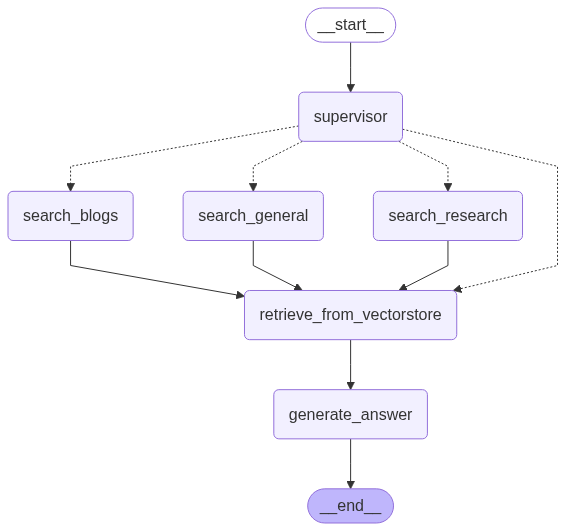

In [15]:
app

In [16]:
def query_supervisor_rag(question: str) -> str:
    """Query the supervisor RAG system"""

    initial_state = {
        "messages": [HumanMessage(content=question)],
        "query": question,
        "query_type": None,
        "search_results": [],
        "retrieved_documents": [],
        "final_answer": "",
        "next_action": ""
    }

    # Run the graph
    result = app.invoke(initial_state)

    return result["final_answer"]

In [17]:
research_answer = query_supervisor_rag("What are the latest developments in transformer neural networks?")
print("Research Answer:", research_answer)

Research Answer: The provided context does not specifically mention the latest developments in transformer neural networks. The context includes two separate summaries of research papers: one on synaptic sampling of neural networks (published in 2023) and another on deep learning for Music Information Retrieval (MIR) (published in 2020). Neither of these summaries directly discusses transformer neural networks or their latest developments.

However, based on general knowledge, transformer neural networks have been a significant area of research and development in the field of artificial intelligence, particularly in natural language processing (NLP) and computer vision. They were introduced in the paper "Attention Is All You Need" by Vaswani et al. in 2017 and have since become a cornerstone in many state-of-the-art models for tasks such as machine translation, text generation, and question-answering.

Some of the latest developments and trends in transformer neural networks include:



In [18]:
general_answer = query_supervisor_rag("What is One Piece in General?")
print("General Answer:", general_answer)

General Answer: The question "What is One Piece in General?" seems unrelated to the provided context about France. However, I'll provide a general answer to the question.

One Piece is a popular Japanese manga and anime series created by Eiichiro Oda. The story follows Monkey D. Luffy, a young boy who becomes a pirate after eating the Gum-Gum Fruit, which gives him the ability to stretch and manipulate his body like rubber. Luffy's dream is to become the Pirate King, and he sets out on a journey to find the legendary treasure known as "One Piece," which will grant him that title.

The series is known for its unique characters, intricate world-building, and epic storylines, which often explore themes of friendship, adventure, and the struggle between good and evil. One Piece has become a cultural phenomenon in Japan and worldwide, with a vast and dedicated fan base. It has been adapted into various forms of media, including anime, movies, video games, and merchandise.

If you're looking

In [19]:
blog_answer = query_supervisor_rag("What are the latest trends in artificial intelligence?")
print("Blog Answer:", blog_answer)

Blog Answer: The latest trends in artificial intelligence, based on the provided context, appear to be focused on the development of probabilistic artificial neural networks and techniques that enable the quantification of uncertainty in AI methods. Specifically, the context highlights the following trends:

1. **Probabilistic Artificial Neural Networks**: There is a growing interest in probabilistic artificial neural networks that can explicitly describe the uncertainty of AI methods. This is seen as a key area of development, with potential applications in various fields.
2. **Monte Carlo Sampling and Stochastic Computing**: The use of Monte Carlo sampling and stochastic computing is being explored as a means to quantify uncertainty in AI methods. However, the high costs of stochastic sampling on deterministic computing hardware have limited the development of these techniques.
3. **Emerging Computing Systems**: The emergence of computing systems that are amenable to hardware-level p

In [22]:
research_answer = query_supervisor_rag("What are the latest Developements in Retrieval Augmented Generation?")
print("Research Answer:", research_answer)

Research Answer: Based on the provided context, it appears that the topic of discussion is Deep Learning for Music Information Retrieval (MIR) and audio retrieval, rather than Retrieval Augmented Generation. The context does not provide any information on the latest developments in Retrieval Augmented Generation.

However, I can provide some general information on Retrieval Augmented Generation. Retrieval Augmented Generation is a technique that combines the strengths of retrieval-based and generation-based approaches in natural language processing and other areas of artificial intelligence. The basic idea is to use a retrieval system to fetch relevant information from a database or knowledge graph, and then use a generation model to create new text or other forms of output based on the retrieved information.

Some of the latest developments in Retrieval Augmented Generation include:

1. **Improved retrieval models**: Researchers have been working on developing more effective retrieval